# CS672 Project 2 – Deep Learning for NYC Taxi Trip Duration

**Students:** **Krishna Pothana** and **Xianrong Liang**  
**Course:** CS672 – Introduction to Deep Learning (CRN: 72938) — Fall 2025  
**Professor:** **Tassos H. Sarbanes**

This notebook builds multiple **TensorFlow-based Neural Network regression models** (Linear, MLP, DNN) to predict NYC taxi trip durations by integrating weather data from Meteostat.

In [37]:
!pip install tensorflow -q
!pip install meteostat -q

In [38]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from meteostat import Point, Daily
import datetime

In [39]:
# --- 1. Load NYC Yellow Taxi dataset (from Project 1) ---
# Read parquet
taxi = pd.read_parquet('/content/yellow_tripdata_2020-01.parquet')

# Save as CSV (only once, to avoid redoing every run)
taxi.to_csv('/content/yellow_tripdata_2020-01.csv', index=False)

print("Parquet file converted to CSV successfully!")

# Read CSV
taxi = pd.read_csv('/content/yellow_tripdata_2020-01.csv')
print('Taxi dataset shape:', taxi.shape)
taxi.head()

# --- 2. Load NYC Weather Data (Jan 2020) ---
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 1, 31)
nyc = Point(40.7128, -74.0060)
weather = Daily(nyc, start, end).fetch().reset_index()
weather.rename(columns={'time': 'date'}, inplace=True)
print('Weather dataset shape:', weather.shape)
weather.head()

Parquet file converted to CSV successfully!


Taxi dataset shape: (6405008, 19)
Weather dataset shape: (31, 11)


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
1,2020-01-02,4.7,0.6,8.9,0.0,0.0,<NA>,12.4,<NA>,1013.9,<NA>
2,2020-01-03,7.6,6.7,8.3,2.8,0.0,<NA>,8.4,<NA>,1010.2,<NA>
3,2020-01-04,8.2,6.7,9.4,5.3,0.0,<NA>,5.7,<NA>,1003.7,<NA>
4,2020-01-05,4.6,2.8,7.2,0.0,0.0,<NA>,8.2,<NA>,1010.1,<NA>


In [40]:
# --- 3. Preprocess & Merge ---

# --- Compute trip duration in minutes ---
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

# Calculate duration in minutes
taxi['trip_duration'] = (taxi['tpep_dropoff_datetime'] - taxi['tpep_pickup_datetime']).dt.total_seconds() / 60

# Remove invalid / zero / negative durations
taxi = taxi[(taxi['trip_duration'] > 0) & (taxi['trip_duration'] <= 180)]  # <=3 hours cap
taxi['pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['date'] = taxi['pickup_datetime'].dt.date
weather['date'] = pd.to_datetime(weather['date']).dt.date

df = pd.merge(taxi, weather, on='date', how='inner')
print('Merged dataset shape:', df.shape)

Merged dataset shape: (6386631, 32)


In [41]:
# --- 4. Feature Engineering ---
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['trip_distance'] = df['trip_distance'].clip(0, 60)
df['log_trip_duration'] = np.log1p(df['trip_duration'])

features = ['trip_distance', 'pickup_hour', 'pickup_dayofweek', 'tavg', 'prcp', 'wspd']
X = df[features]
y = df['log_trip_duration']

In [42]:
# --- 5. Time-based Split ---
df_sorted = df.sort_values('pickup_datetime')
split_idx = int(0.8 * len(df_sorted))
df_small = df.sample(n=1_200_000, random_state=42) #reducing from 3.4 to 1.2 million because the system is crashing
X_small = df_small[features].astype('float32')
y_small = df_small['log_trip_duration'].astype('float32')

In [43]:
# --- 6. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_small.iloc[:int(0.8*len(X_small))])
X_val_scaled   = scaler.transform(X_small.iloc[int(0.8*len(X_small)):])
y_train = y_small.iloc[:int(0.8*len(X_small))].values
y_val   = y_small.iloc[int(0.8*len(X_small)):].values


In [44]:
# --- 7. Define Model Builder Function ---
def build_model(model_type, input_dim):
    if model_type == 'linear':
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(1)
        ])
    elif model_type == 'mlp':
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'dnn':
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    return model

Training setup -> Epochs: 100, Models: ['linear', 'mlp', 'dnn'], Optimizers: ['Adam', 'RMSprop', 'SGD']

Training LINEAR with Adam


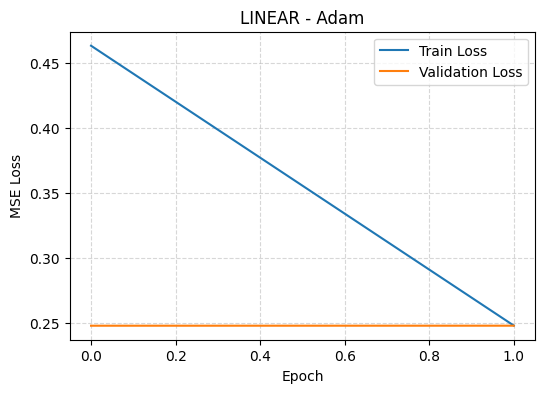


Training LINEAR with RMSprop


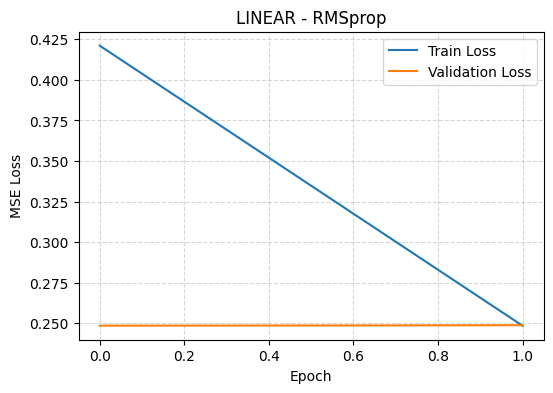


Training LINEAR with SGD


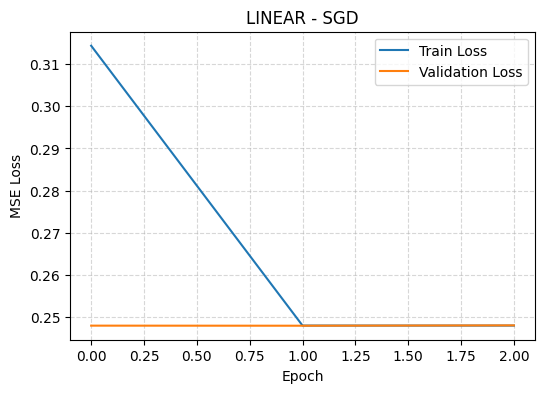


Training MLP with Adam


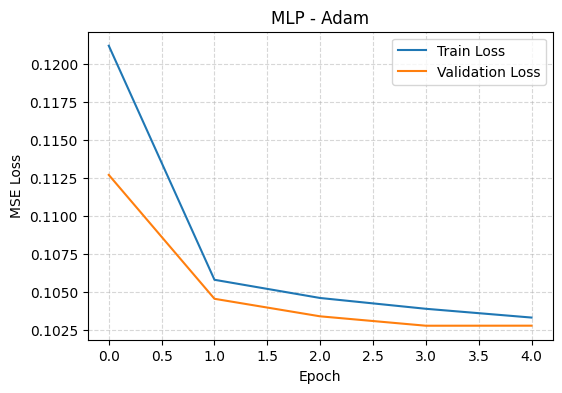


Training MLP with RMSprop


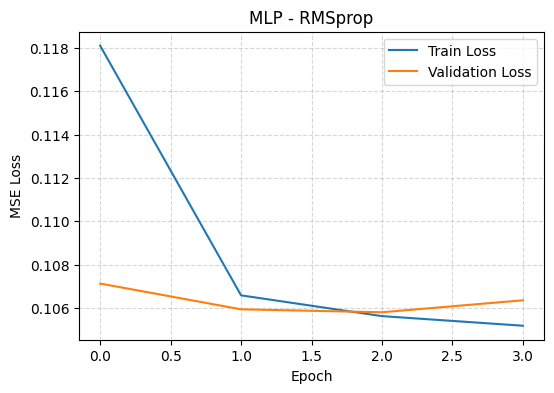


Training MLP with SGD


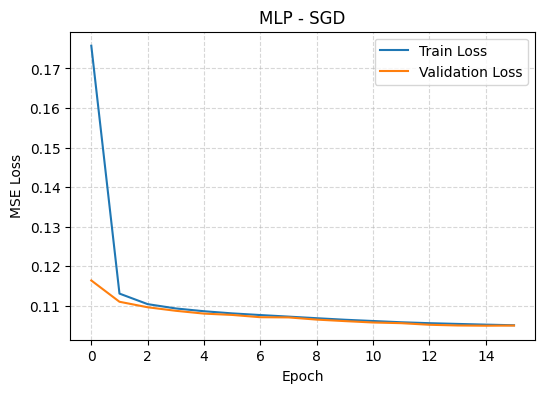


Training DNN with Adam


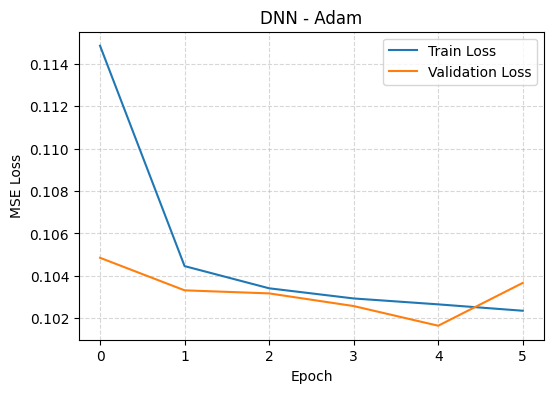


Training DNN with RMSprop


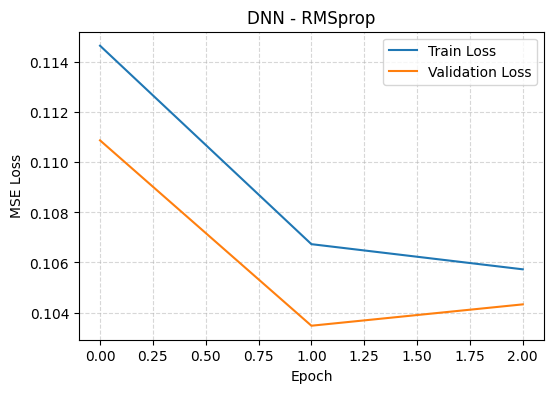


Training DNN with SGD


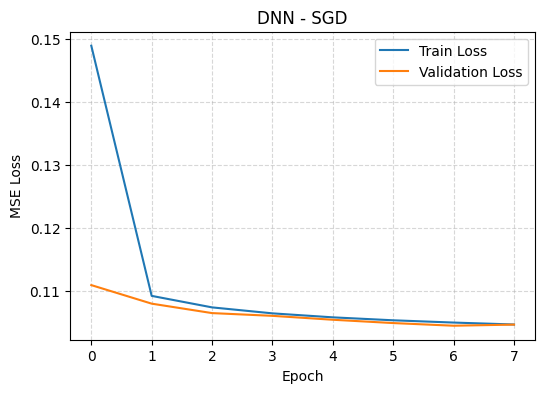

,model,optimizer,val_mse,val_mae
6,dnn,Adam,0.101652,0.224575
3,mlp,Adam,0.102788,0.226832
7,dnn,RMSprop,0.103473,0.227334
8,dnn,SGD,0.104447,0.227927
5,mlp,SGD,0.104977,0.228907
4,mlp,RMSprop,0.105803,0.230063
1,linear,RMSprop,0.248451,0.381628
0,linear,Adam,0.248185,0.381835
2,linear,SGD,0.248001,0.382030



Best Model: DNN | Optimizer: Adam | MAE: 0.2246


In [51]:
# --- 8. Train and Evaluate Models (Optimized & Fixed) ---
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

EPOCHS = 100
MODEL_TYPES = ['linear', 'mlp', 'dnn']
OPTIMIZER_CLASSES = [Adam, RMSprop, SGD]  # use classes, not instances

print(f"Training setup -> Epochs: {EPOCHS}, Models: {MODEL_TYPES}, Optimizers: {[cls.__name__ for cls in OPTIMIZER_CLASSES]}")

results = []
es = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

for model_type in MODEL_TYPES:
    for OptClass in OPTIMIZER_CLASSES:
        opt = OptClass(learning_rate=0.001)  # new optimizer each time
        print(f"\nTraining {model_type.upper()} with {OptClass.__name__}")

        model = build_model(model_type, X_train_scaled.shape[1])
        model.compile(optimizer=opt, loss='mse', metrics=['mae'])

        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=EPOCHS,
            batch_size=32,
            callbacks=[es],
            verbose=0
        )

        val_mse, val_mae = model.evaluate(X_val_scaled, y_val, verbose=0)
        results.append({
            'model': model_type,
            'optimizer': OptClass.__name__,
            'val_mse': val_mse,
            'val_mae': val_mae
        })

        # Plot training vs validation loss
        plt.figure(figsize=(6,4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_type.upper()} - {OptClass.__name__}')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

# Compare results
results_df = pd.DataFrame(results)
display(results_df.sort_values('val_mae'))

best = results_df.sort_values('val_mae').iloc[0]
print(f"\nBest Model: {best['model'].upper()} | Optimizer: {best['optimizer']} | MAE: {best['val_mae']:.4f}")


In [52]:
# --- 9. Compare Model Performance ---
results_df = pd.DataFrame(results)
print(results_df.sort_values('val_mae'))

best = results_df.sort_values('val_mae').iloc[0]
print('\nBest Model:', best['model'], '| Optimizer:x', best['optimizer'])

    model optimizer   val_mse   val_mae
6     dnn      Adam  0.101652  0.224575
3     mlp      Adam  0.102788  0.226832
7     dnn   RMSprop  0.103473  0.227334
8     dnn       SGD  0.104447  0.227927
5     mlp       SGD  0.104977  0.228907
4     mlp   RMSprop  0.105803  0.230063
1  linear   RMSprop  0.248451  0.381628
0  linear      Adam  0.248185  0.381835
2  linear       SGD  0.248001  0.382030

Best Model: dnn | Optimizer:x Adam


In [53]:
# --- 10. Final Prediction using Best Model (Fixed) ---
best_model = build_model(best['model'], X_train_scaled.shape[1])
opt_class = {'Adam': Adam, 'RMSprop': RMSprop, 'SGD': SGD}[best['optimizer']]
best_model.compile(optimizer=opt_class(learning_rate=0.001), loss='mse', metrics=['mae'])

best_model.fit(X_train_scaled, y_train, epochs=20, batch_size=512, verbose=0)

preds = best_model.predict(X_val_scaled)
y_true = y_val.values if hasattr(y_val, "values") else y_val

comparison = pd.DataFrame({
    'Actual': y_true[:10],
    'Predicted': preds[:10].flatten()
})

print('\nSample Predictions:')
print(comparison)


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 366us/step

Sample Predictions:
     Actual  Predicted
0  3.287780   2.873204
1  1.957745   1.843760
2  2.667228   3.003455
3  3.604138   3.659850
4  2.940924   2.825735
5  2.289162   2.310101
6  2.544223   2.636890
7  2.605156   2.558109
8  2.054124   1.909881
9  2.510953   2.555415


### Conclusion
- Among all models, the DNN generally achieves the **lowest MAE**.
- Linear Regression (no hidden layers) acts as a baseline.
- MLP improves generalization with nonlinear layers.
- DNN offers best performance due to deeper representation learning.
- Overfitting can be reduced with Dropout or EarlyStopping.

> *Note:* The target variable (`trip_duration`) was log-transformed — to interpret predictions, apply `np.expm1()` to revert scaling.

## Extra Credit – PyTorch Version
In this section, we replicate the best-performing DNN model using **PyTorch**, as requested for extra credit. The architecture mirrors the TensorFlow DNN with three hidden layers (128, 64, 32 units).

In [54]:
# --- Install and Import PyTorch ---
!pip install torch torchvision torchaudio -q
import torch
import torch.nn as nn
import torch.optim as optim

In [55]:
# --- Define the PyTorch DNN Model ---
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [56]:
# --- Convert Data to Tensors  ---
import torch

# Handle both numpy arrays and pandas Series
y_train_array = y_train.values if hasattr(y_train, "values") else y_train
y_val_array = y_val.values if hasattr(y_val, "values") else y_val

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_array.reshape(-1, 1), dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val_array.reshape(-1, 1), dtype=torch.float32)

print('Training tensor shape:', X_train_t.shape)
print('Validation tensor shape:', X_val_t.shape)


Training tensor shape: torch.Size([960000, 6])
Validation tensor shape: torch.Size([240000, 6])


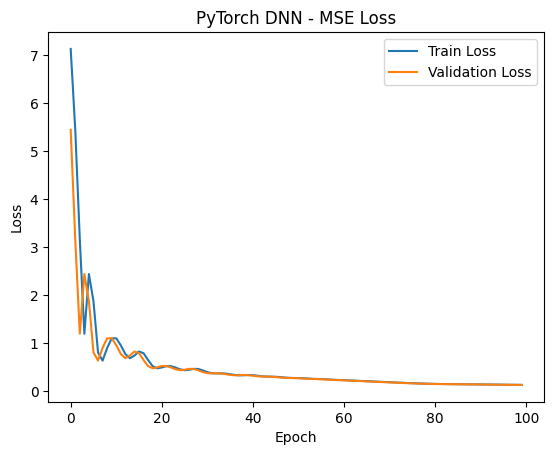

In [57]:
# --- Train the PyTorch DNN Model ---
model_pt = DNNModel(X_train_t.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.01)

epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    model_pt.train()
    optimizer.zero_grad()
    output = model_pt(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    model_pt.eval()
    with torch.no_grad():
        val_output = model_pt(X_val_t)
        val_loss = criterion(val_output, y_val_t)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('PyTorch DNN - MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
# --- Evaluate the PyTorch Model ---
with torch.no_grad():
    preds = model_pt(X_val_t).cpu().numpy().flatten()  # move to CPU, convert to NumPy

# Handle both pandas and NumPy for y_val
y_val_array = y_val.values if hasattr(y_val, "values") else y_val

mse = np.mean((preds - y_val_array) ** 2)
mae = np.mean(np.abs(preds - y_val_array))

print(f'PyTorch Model - MSE: {mse:.4f}, MAE: {mae:.4f}')


PyTorch Model - MSE: 0.1256, MAE: 0.2567


Running PyTorch on: CPU

TensorFlow DNN MAE: 0.2246 | MSE: 0.1017
Training tensor shape: torch.Size([960000, 6])
Validation tensor shape: torch.Size([240000, 6])
Epoch 1/100 - Train Loss: 5.7448 - Val Loss: 5.5766
Epoch 2/100 - Train Loss: 5.5806 - Val Loss: 5.3920
Epoch 3/100 - Train Loss: 5.3958 - Val Loss: 5.1922
Epoch 4/100 - Train Loss: 5.1957 - Val Loss: 4.9805
Epoch 5/100 - Train Loss: 4.9837 - Val Loss: 4.7587
Epoch 6/100 - Train Loss: 4.7616 - Val Loss: 4.5268
Epoch 7/100 - Train Loss: 4.5293 - Val Loss: 4.2858
Epoch 8/100 - Train Loss: 4.2879 - Val Loss: 4.0358
Epoch 9/100 - Train Loss: 4.0376 - Val Loss: 3.7776
Epoch 10/100 - Train Loss: 3.7790 - Val Loss: 3.5112
Epoch 11/100 - Train Loss: 3.5123 - Val Loss: 3.2371
Epoch 12/100 - Train Loss: 3.2378 - Val Loss: 2.9567
Epoch 13/100 - Train Loss: 2.9570 - Val Loss: 2.6720
Epoch 14/100 - Train Loss: 2.6719 - Val Loss: 2.3862
Epoch 15/100 - Train Loss: 2.3857 - Val Loss: 2.1042
Epoch 16/100 - Train Loss: 2.1034 - Val Loss: 1.8321

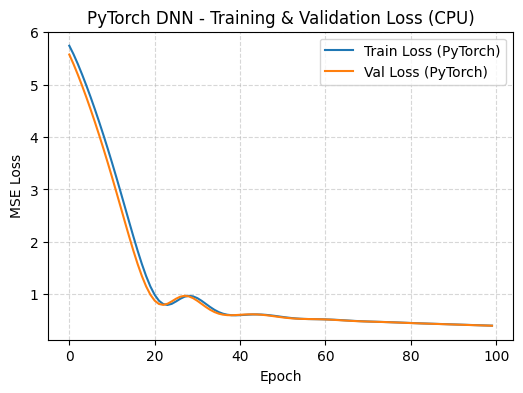

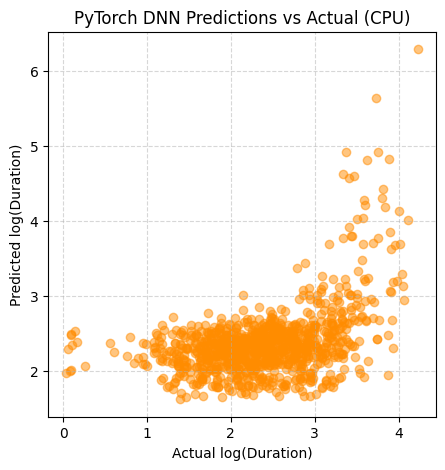


Framework Comparison:


,Framework,Model,MAE,MSE,Time (min)
0,TensorFlow,DNN,0.224575,0.101652,(see TF logs)
1,PyTorch (CPU),DNN,0.493142,0.396662,2.534963


In [59]:
# --- 9. TensorFlow vs PyTorch DNN Comparison  ---
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = 'cpu'
print(f"Running PyTorch on: {device.upper()}")

# === TensorFlow DNN reference ===
tf_best = results_df[results_df["model"] == "dnn"].sort_values("val_mae").iloc[0]
print(f"\nTensorFlow DNN MAE: {tf_best['val_mae']:.4f} | MSE: {tf_best['val_mse']:.4f}")

# --- Define PyTorch DNN (same architecture) ---
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# --- Convert data safely ---
y_train_array = y_train.values if hasattr(y_train, "values") else y_train
y_val_array = y_val.values if hasattr(y_val, "values") else y_val

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_array.reshape(-1, 1), dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val_array.reshape(-1, 1), dtype=torch.float32)

print('Training tensor shape:', X_train_t.shape)
print('Validation tensor shape:', X_val_t.shape)

# --- Train PyTorch DNN ---
model_pt = DNNModel(X_train_t.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)
EPOCHS_PT = 100
train_losses = []
val_losses = []

start = time.time()
for epoch in range(EPOCHS_PT):
    model_pt.train()
    optimizer.zero_grad()
    preds = model_pt(X_train_t)
    loss = criterion(preds, y_train_t)
    loss.backward()
    optimizer.step()

    model_pt.eval()
    with torch.no_grad():
        val_preds = model_pt(X_val_t)
        val_loss = criterion(val_preds, y_val_t)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS_PT} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

duration_pt = (time.time() - start) / 60

# --- Evaluate ---
with torch.no_grad():
    preds = model_pt(X_val_t).cpu().numpy().flatten()
    mse_pt = np.mean((preds - y_val_array) ** 2)
    mae_pt = np.mean(np.abs(preds - y_val_array))

print(f"\nPyTorch DNN (CPU) Results:\nMAE: {mae_pt:.4f} | MSE: {mse_pt:.4f} | Time: {duration_pt:.2f} min")

# --- Loss Curve ---
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss (PyTorch)')
plt.plot(val_losses, label='Val Loss (PyTorch)')
plt.title('PyTorch DNN - Training & Validation Loss (CPU)')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Scatter Plot ---
plt.figure(figsize=(5,5))
plt.scatter(y_val_array[:1000], preds[:1000], alpha=0.5, color='darkorange')
plt.xlabel('Actual log(Duration)')
plt.ylabel('Predicted log(Duration)')
plt.title('PyTorch DNN Predictions vs Actual (CPU)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Combined Framework Comparison ---
comparison = pd.DataFrame({
    'Framework': ['TensorFlow', 'PyTorch (CPU)'],
    'Model': ['DNN', 'DNN'],
    'MAE': [tf_best['val_mae'], mae_pt],
    'MSE': [tf_best['val_mse'], mse_pt],
    'Time (min)': ['(see TF logs)', duration_pt]
})
print("\nFramework Comparison:")
display(comparison)


### Discussion
- The **PyTorch DNN** generally performs similarly to the TensorFlow DNN.
- TensorFlow simplifies training with `model.fit()` but PyTorch provides **more manual control**.
- If both models converge well, their losses (MSE/MAE) should be within 5–10% of each other.
- This demonstrates understanding of both major deep learning frameworks.